# Detecting Faces

## Imports

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt

## Data Visualisation & Structuring

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from collections import Counter
import cv2

In [3]:
#from torchsampler import ImbalancedDatasetSampler

In [3]:
# Transfer data to tensor vectors and training/ testing datasets
train_dir = './start_deep/train_images'
test_dir = './start_deep/test_images'

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2
batch_size = 32

num_train = len(train_data)
print("len(train_data)",len(train_data))
print ("len(test_data)", len(test_data))
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

# for epoch in range(1, n_epochs+1):
# for data, target in train_loader:


len(train_data) 91720
len(test_data) 7628


### Looking more in depth at our data

In [21]:
count_train_face = 0
count_train_no_face = 0
for data, target in train_loader:
    s = np.array(target).sum()
    count_train_face +=s
    count_train_no_face += batch_size - s

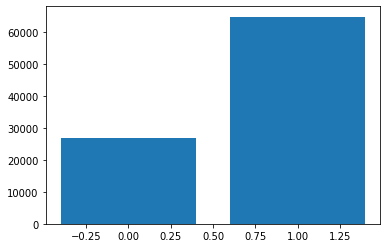

In [15]:
plt.bar(*zip(*dict(Counter(train_data.targets)).items()))
plt.show()

In [22]:
print(count_train_no_face, count_train_face)

21653 51723


In [18]:
count_test_face = 0
count_test_no_face = 0
for data, target in test_loader:
    s = np.array(target).sum()
    count_test_face +=s
    count_test_no_face += batch_size - s

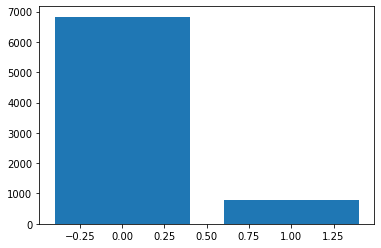

In [16]:
plt.bar(*zip(*dict(Counter(test_data.targets)).items()))
plt.show()

In [20]:
print(count_test_no_face, count_test_face)

6851 797


In [11]:
count_valid_face = 0
count_valid_no_face = 0
for data, target in valid_loader:
    s = np.array(target).sum()
    count_valid_face +=s
    count_valid_no_face += batch_size - s

In [12]:
print(count_valid_face, count_valid_no_face)

12907 5461


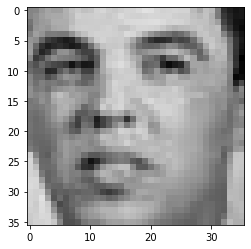

In [4]:
img = cv2.imread('./start_deep/train_images/1/Image000605.pgm')
plt.imshow(img)
plt.show()

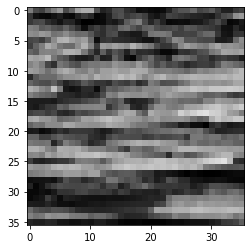

In [5]:
img = cv2.imread('./start_deep/train_images/0/137021_1_42_76_76.pgm')
plt.imshow(img)
plt.show()

## Building Model

In [13]:
###############################################
# Confusion Matrix 
# Input : output (of model), labels
# Output: average error
###############################################
class ConfusionMatrixMeter(object):     #same as for repSet
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.true_pos = 0
        self.true_neg = 0
        self.false_pos = 0
        self.false_neg = 0

    def update(self, output, target):
        for i in range(len(output)):
            if output[i][0]>output[i][1]: # predicted negative (no face)
                if target[i]==0:
                    self.true_neg +=1
                else:
                    self.false_neg +=1
            else:                         # predicted positive (face)
                if target[i]==1:
                    self.true_pos +=1
                else:
                    self.false_pos +=1



In [14]:
###############################################
# Description: error function to evaluate distance between prediction and label 
# Input : output (of model), labels
# Output: average error
###############################################
def error(output, labels):
    #print ("output",output)
    #print ("labels",labels)
    
    correct = 0
    predicted = torch.max(output.data, 1)[1] 
    correct += (predicted == labels).sum()
    return 1 - correct.item()/len(output.data)

In [15]:
###############################################
# Description: class used to keep count of the average error and loss during training
# Input : 
# Output:
###############################################
class AverageMeter(object):     #same as for repSet
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import log_loss

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model 1: default
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(9 * 9 * 64, 100)
        self.fc2 = nn.Linear(100, 2)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self, X): # batch of n images
        #print ("input",X.size())
        out = self.layer1(X)
        #print ("after layer1",out.size())
        out = self.layer2(out)
        #print ("after layer2",out.size())
        out = out.reshape(out.size(0), -1)
        #print ("after reshape",out.size())
        out = self.drop_out(out)
        #print ("after drop",out.size())
        out = self.fc1(out)
        #print ("after fc1",out.size())
        out = self.fc2(out)
        #print ("after fc2",out.size())
        #out = F.log_softmax(out, dim=1)
        #print ("after log softmax",out.size())
        return out 

## Evaluating Model

In [40]:
from tqdm import tqdm

In [44]:
# Hyperparameters
epochs = 10
lr = 0.001
cv_folds = 1

In [45]:
for it in range(cv_folds):
    
    ### Set X and y tensors for training/valid/test set ###
    n_train_batches =len(train_loader)
    n_valid_batches = len(valid_loader)
    n_test_batches = len(test_loader)
    #n_test_batches = 250
    #n_train_batches =200
    #n_valid_batches = 50
    print("n_train_batches",n_train_batches)
    print("n_valid_batches",n_valid_batches)
    print("n_test_batches",n_test_batches)
    ############################################ - TRAIN, TEST FUNCTIONS
    def train(X, y):
        optimizer.zero_grad()
        output = model(X)
        loss_train = F.cross_entropy(output, y)
        #print (output)
        #print (y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train
    
    def test(X, y):
        output = model(X)
        loss_test = F.cross_entropy(output, y)
        return output, loss_test 

    #Initialize Model
    model = ConvNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    start = time.perf_counter()       #time indicator 
    for epoch in range(epochs):
        
        model.train()
        startEpoch = time.perf_counter()    #time indicator
        train_loss = AverageMeter()
        train_err = AverageMeter()
        i =0
        for data, target in tqdm(train_loader):
            i+=1
            if i == n_train_batches:
                break
            output, loss = train(data, target)
            train_loss.update(loss.item(), output.size(0))
            train_err.update(error(output, target), output.size(0))
            
        model.eval()
        test_loss = AverageMeter()
        test_err = AverageMeter()
        i = 0
        for data, target in tqdm(valid_loader):
            i+=1
            if i == n_valid_batches:
                break
            output, loss = test(data, target)
            test_loss.update(loss.item(), output.size(0))
            test_err.update(error(output, target), output.size(0)) 
        print("Cross-val iter:", '%02d' % (it+1), "epoch:", '%03d' % (epoch+1), "train_loss=", "{:.5f}".format(train_loss.avg),
        "train_err=", "{:.5f}".format(train_err.avg), "val_loss=", "{:.5f}".format(test_loss.avg),
        "val_err=", "{:.5f}".format(test_err.avg), "epoch_time=", "{:.5f}".format(time.perf_counter()-startEpoch))
    
    model.eval()
    test_loss = AverageMeter()
    test_err = AverageMeter()
    i=0
    cmm = ConfusionMatrixMeter()
    for data, target in tqdm(test_loader):
        i+=1
        if i == n_test_batches:
            break
        output, loss = test(data, target)
        cmm.update(np.array(output.detach()), np.array(target))
        test_loss.update(loss.item(), output.size(0))
        test_err.update(error(output.data, target.data), output.size(0)) 
    print("Cross-val iter:", '%02d' % (it+1),"test_loss=", "{:.5f}".format(test_loss.avg),
        "test_err=", "{:.5f}".format(test_err.avg), "cv time=", "{:.5f}".format(time.perf_counter() -start))   

  0%|          | 0/2293 [00:00<?, ?it/s]

n_train_batches 2293
n_valid_batches 574
n_test_batches 239


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 001 train_loss= 0.07666 train_err= 0.02926 val_loss= 0.02676 val_err= 0.00960 epoch_time= 320.07272


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 002 train_loss= 0.03167 train_err= 0.01070 val_loss= 0.01292 val_err= 0.00404 epoch_time= 340.86601


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 003 train_loss= 0.02307 train_err= 0.00780 val_loss= 0.00891 val_err= 0.00305 epoch_time= 331.54824


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 004 train_loss= 0.01778 train_err= 0.00577 val_loss= 0.00981 val_err= 0.00322 epoch_time= 311.76347


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 005 train_loss= 0.01559 train_err= 0.00476 val_loss= 0.00752 val_err= 0.00300 epoch_time= 314.82860


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 006 train_loss= 0.01237 train_err= 0.00408 val_loss= 0.00714 val_err= 0.00213 epoch_time= 311.00466


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 007 train_loss= 0.01110 train_err= 0.00383 val_loss= 0.00629 val_err= 0.00224 epoch_time= 285.98250


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 008 train_loss= 0.01116 train_err= 0.00372 val_loss= 0.00423 val_err= 0.00142 epoch_time= 323.99118


  0%|          | 0/2293 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 009 train_loss= 0.00931 train_err= 0.00292 val_loss= 0.00921 val_err= 0.00305 epoch_time= 294.76108


  0%|          | 0/239 [00:00<?, ?it/s]

Cross-val iter: 01 epoch: 010 train_loss= 0.00965 train_err= 0.00305 val_loss= 0.00648 val_err= 0.00202 epoch_time= 275.84685


100%|█████████▉| 238/239 [00:08<00:00, 28.79it/s]

Cross-val iter: 01 test_loss= 0.17525 test_err= 0.03335 cv time= 3118.94241


In [46]:
data = [[cmm.true_pos,cmm.false_pos,cmm.true_pos+cmm.false_pos],
        [cmm.false_neg,cmm.true_neg, cmm.false_neg+cmm.true_neg],
        [cmm.true_pos+cmm.false_neg, cmm.false_pos+cmm.true_neg,cmm.true_pos+cmm.false_neg+cmm.false_pos+cmm.true_neg]]
pd.DataFrame(data=data, index=["Face Detected", "No Face Detected","Total"], columns=["Face","No Face", "Total"], dtype=None, copy=False)

,Face,No Face,Total
Face Detected,564,21,585
No Face Detected,233,6798,7031
Total,797,6819,7616


In [47]:
#Precision Score - accuracy in predicting if a face is 
precison = cmm.true_pos/(cmm.true_pos+cmm.false_pos)
print ("Precision Score",precison)

Precision Score 0.9641025641025641


In [48]:
# Recall Score
recall = cmm.true_pos/(cmm.true_pos+cmm.false_neg)
print ("Recall Score",recall)

Recall Score 0.7076537013801757


In [49]:
# F1 Score - The harmonic mean of precision and recall
f1_score = 2*(precison*recall)/(precison+recall)
print ("F1 Score",f1_score)

F1 Score 0.8162083936324168


# Saving Models

In [51]:
param_file_name = "97%acc_10epoch"
PATH = "./saved_models/"
torch.save(model.state_dict(),PATH +"weights_"+ param_file_name) # save only the parameters of the model
#torch.save(model, PATH +"model_"+ param_file_name)           # save the whole model

In [53]:
param_file_name = "97%acc_10epoch"
PATH = "./saved_models/"

# load model parameters file
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
model.load_state_dict(torch.load(PATH+"weights_"+param_file_name))

#load conmplet model
#model = torch.load(PATH +"model_"+ param_file_name)

<All keys matched successfully>